In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from simple_block import simple
import jacobian as jac
from het_block import het
import scipy.optimize as opt

In [2]:
@het(exogenous='Pi', policy='a', backward='Va')
def household(Va_p, Pi_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (S*A), marginal value of assets tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount rate today
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    uc_nextgrid = (beta * Pi_p) @ Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = utils.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    utils.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

In [3]:
def ks_ss(lb=0.98, ub=0.999, r=0.01, eis=1, delta=0.025, alpha=0.11, rho=0.966, sigma=0.5, nS=7, nA=500, amax=200):
    """Solve steady state of full GE model. Calibrate beta to hit target for interest rate.
    
    Parameters
    ----------
    lb    : scalar, lower bound of interval bracketing beta
    ub    : scalar, upper bound of interval bracketing beta
    r     : scalar, real interest rate
    eis   : scalar, elasticity of intertemporal substitution
    delta : scalar, depreciation rate
    alpha : scalar, capital share
    rho   : scalar, autocorrelation of income process
    sigma : scalar, cross-sectional sd of log income
    nS    : int, number of income gridpoints
    nA    : int, number of capital gridpoints
    amax  : scalar, upper bound of capital grid

    Returns
    ----------
    ss : dict, steady state values
    """
    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_s, Pi = utils.markov_rouwenhorst(rho=rho, sigma=sigma, N=nS)
    
    # solve analytically what we can
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))
    
    # initialize guess for policy function iteration
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # solve for beta
    beta_min = lb / (1 + r)
    beta_max = ub / (1 + r)
    beta, sol = opt.brentq(lambda bet: household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=bet, eis=eis,
                                                    Va=Va)['A'] - K, beta_min, beta_max, full_output=True)
    if not sol.converged:
        raise ValueError('Steady-state solver did not converge.')

    # extra evaluation for reporting
    ss = household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=beta, eis=eis, Va=Va)
    
    # check Walras's law
    walras = Y - ss['C'] - delta * K
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'w': w, 'Z': Z, 'K': K, 'L': 1, 'Y': Y, 'alpha': alpha, 'delta': delta, 'walras': walras})

    return ss

In [4]:
ss2 = ks_ss()

In [7]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def mkt_clearing(K, A):
    asset_mkt = A - K
    return asset_mkt

In [9]:
T = 300
G2 = jac.get_G(block_list=[firm, mkt_clearing, household],  # we could replace household with J_ha here
               exogenous=['Z'],
               unknowns=['K'],
               targets=['asset_mkt'],
               T=T, ss=ss2)

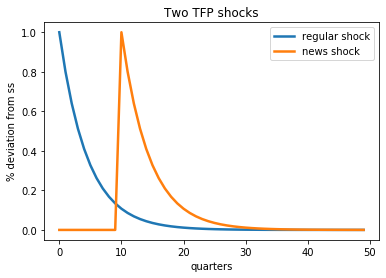

In [11]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ2 = np.empty((T, 2))
dZ2[:, 0] = impact * ss2['Z'] * rho**np.arange(T)
dZ2[:, 1] = np.concatenate((np.zeros(news), dZ2[:-news, 0])) 

plt.plot(100*dZ2[:50, 0]/ss2['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ2[:50, 1]/ss2['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

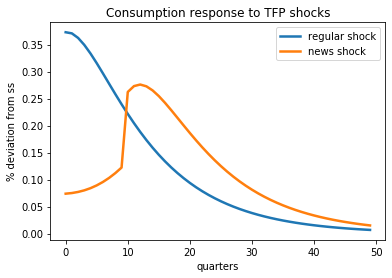

In [13]:
dC2 = 100 * G2['C']['Z'] @ dZ2 / ss2['C']
plt.plot(dC2[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC2[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [14]:
print(ss2['beta'])

0.9819527880123726


In [16]:
def rbc_ss(beta=0.99, eis=1, Z=1, delta=0.025, alpha=0.11):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    beta   : scalar, discount rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    r = 1/beta - 1
    rk = r + delta
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [17]:
ss1 = rbc_ss(beta=ss2['beta'],Z=ss2['Z'])
print(ss1)

{'beta': 0.9819527880123726, 'eis': 1, 'delta': 0.025, 'alpha': 0.11, 'Z': 0.8816460975214567, 'K': 2.469413133939355, 'I': 0.06173532834848388, 'Y': 0.9738220465846438, 'L': 1, 'C': 0.9120867182361599, 'w': 0.866701621460333, 'r': 0.018378899890042266, 'walras': 0.0}


In [18]:
[ss2['Z'],ss2['beta'],ss2['K']]

[0.8816460975214567, 0.9819527880123726, 3.1428571428571432]

In [19]:
[ss1['Z'],ss1['beta'],ss1['K']]

[0.8816460975214567, 0.9819527880123726, 2.469413133939355]

In [20]:
@simple
def household(Y, K, L, w, eis, delta):
    I = K - (1 - delta) * K(-1)
    C = Y - I
    return C, I

@simple
def mkt_clearing(r, w, C, Y, K, L, eis, beta):
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return euler, walras

In [21]:
G1 = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K'],
              targets=['euler'],
              T=300, ss=ss1)

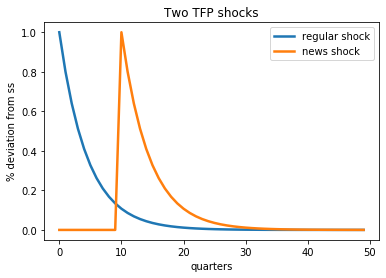

In [23]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ1 = np.empty((T, 2))
dZ1[:, 0] = impact * ss1['Z'] * rho**np.arange(T)
dZ1[:, 1] = np.concatenate((np.zeros(news), dZ1[:-news, 0])) 

plt.plot(100*dZ1[:50, 0]/ss1['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ1[:50, 1]/ss1['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

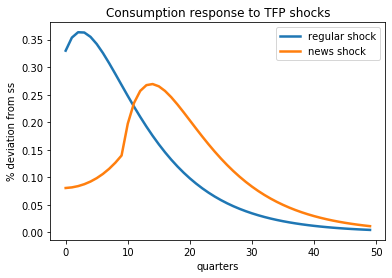

In [24]:
dC1 = 100 * G1['C']['Z'] @ dZ1 / ss1['C']
plt.plot(dC1[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC1[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

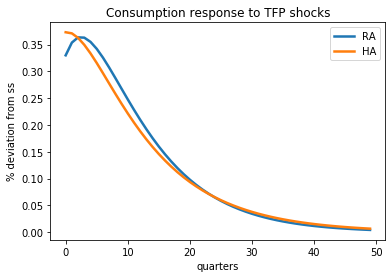

In [25]:
plt.plot(dC1[:50, 0], label='RA', linewidth=2.5)
plt.plot(dC2[:50, 0], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

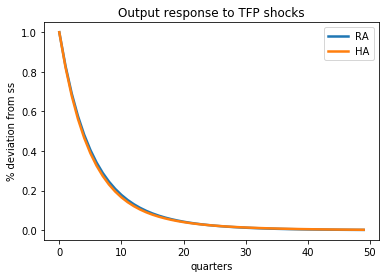

In [27]:
dY1 = 100 * G1['Y']['Z'] @ dZ1 / ss1['Y']
dY2 = 100 * G2['Y']['Z'] @ dZ2 / ss2['Y']
plt.plot(dY1[:50, 0], label='RA', linewidth=2.5)
plt.plot(dY2[:50, 0], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

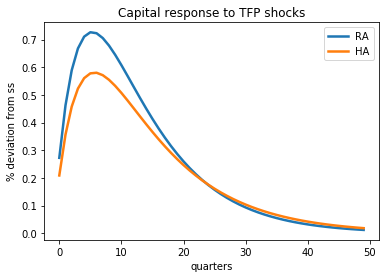

In [29]:
dK1 = 100 * G1['K']['Z'] @ dZ1 / ss1['K']
dK2 = 100 * G2['K']['Z'] @ dZ2 / ss2['K']
plt.plot(dK1[:50, 0], label='RA', linewidth=2.5)
plt.plot(dK2[:50, 0], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Capital response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()